In [2]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LogisticRegression,
    Trainer
)

# User-defined functions
from utils.preprocess import clusters, categorical

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [3]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 20
SIZE = 100
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
X, y = clusters(SIZE, means=[(-3, -3), (2, 2), (-2, 2)], stds=[0.8, 0.6, 0.7])

In [5]:
print("Generated X:", X, "\nGenerated y:", y, sep='\n')
print("\nShape of X: ", X.shape, "\nShape of y: ", y.shape, sep='\n')

Generated X:
tensor([[-3.6530, -3.7819],
        [-3.6839, -3.3250],
        [-1.5881, -2.2060],
        [-2.1353, -2.1327],
        [-2.5513, -2.9084],
        [-2.9985, -3.9606],
        [-2.6949, -4.1618],
        [-3.6012, -3.1351],
        [-3.3913, -1.9856],
        [-2.8423, -3.2706],
        [-1.4877, -2.0439],
        [-2.7971, -2.9921],
        [-3.2251, -3.4608],
        [-1.9210, -2.6367],
        [-3.0652, -3.5381],
        [-3.0323, -2.8398],
        [-1.8172, -3.1419],
        [-3.1479, -2.6811],
        [-3.7213, -2.4980],
        [-2.4382, -3.7161],
        [-2.6047, -3.4250],
        [-2.6305, -2.2257],
        [-3.6586, -3.2549],
        [-2.0468, -2.7750],
        [-3.7297, -5.0557],
        [-2.9229, -1.0075],
        [-2.4984, -3.4608],
        [-2.7762, -4.2607],
        [-1.8001, -3.8012],
        [-2.2393, -1.5569],
        [-2.5278, -4.0542],
        [-3.8498, -4.0640],
        [-3.2775, -3.3257],
        [-2.9609, -3.3353],
        [-2.1670, -1.7814],
       

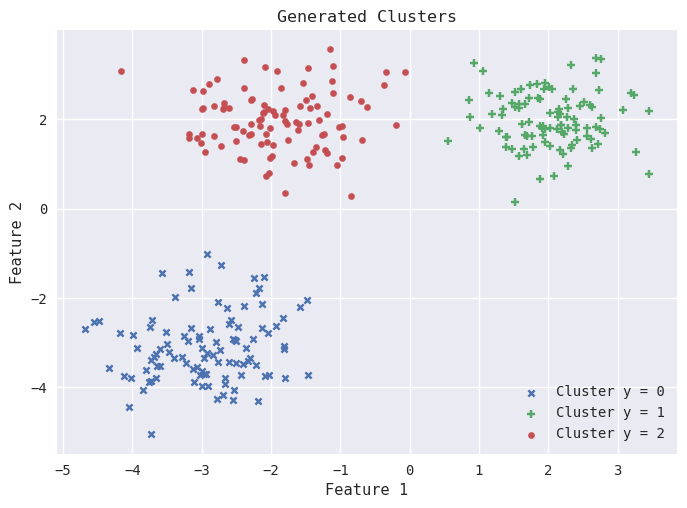

In [6]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='Cluster y = 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='Cluster y = 1', s=40)
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], marker='o', label='Cluster y = 2', s=20)
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Generated Clusters')
plt.show()

In [7]:
y_encoded = categorical(y.int(), 3)
print(f"New y (One-Hot Encoded):\n{y_encoded}")

New y (One-Hot Encoded):
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
       

In [8]:
Model = LogisticRegression(in_dims=2, out_dims=3, multinomial=True).to(DEVICE)

In [9]:
Data = TensorDataset(X, y_encoded)
Data.tensors

(tensor([[-3.6530, -3.7819],
         [-3.6839, -3.3250],
         [-1.5881, -2.2060],
         [-2.1353, -2.1327],
         [-2.5513, -2.9084],
         [-2.9985, -3.9606],
         [-2.6949, -4.1618],
         [-3.6012, -3.1351],
         [-3.3913, -1.9856],
         [-2.8423, -3.2706],
         [-1.4877, -2.0439],
         [-2.7971, -2.9921],
         [-3.2251, -3.4608],
         [-1.9210, -2.6367],
         [-3.0652, -3.5381],
         [-3.0323, -2.8398],
         [-1.8172, -3.1419],
         [-3.1479, -2.6811],
         [-3.7213, -2.4980],
         [-2.4382, -3.7161],
         [-2.6047, -3.4250],
         [-2.6305, -2.2257],
         [-3.6586, -3.2549],
         [-2.0468, -2.7750],
         [-3.7297, -5.0557],
         [-2.9229, -1.0075],
         [-2.4984, -3.4608],
         [-2.7762, -4.2607],
         [-1.8001, -3.8012],
         [-2.2393, -1.5569],
         [-2.5278, -4.0542],
         [-3.8498, -4.0640],
         [-3.2775, -3.3257],
         [-2.9609, -3.3353],
         [-2.1

In [10]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, generator=GENERATOR, shuffle=True)

In [11]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.CrossEntropyLoss(reduction='mean'),        # Cross-entropy Loss (For classification)
    device=DEVICE
)

In [12]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

: 100%|██████████| 8/8 [00:00<00:00, 31.55it/s]


Loss: 1.1495
	| Validation Loss: 1.1287



: 100%|██████████| 8/8 [00:00<00:00, 1000.07it/s]


Loss: 1.0414
	| Validation Loss: 0.9613



: 100%|██████████| 8/8 [00:00<00:00, 972.25it/s]


Loss: 0.8934
	| Validation Loss: 0.8128



: 100%|██████████| 8/8 [00:00<00:00, 888.95it/s]


Loss: 0.7770
	| Validation Loss: 0.7318



: 100%|██████████| 8/8 [00:00<00:00, 1000.22it/s]


Loss: 0.7055
	| Validation Loss: 0.6853



: 100%|██████████| 8/8 [00:00<00:00, 847.36it/s]


Loss: 0.6707
	| Validation Loss: 0.6581



: 100%|██████████| 8/8 [00:00<00:00, 1137.82it/s]


Loss: 0.6471
	| Validation Loss: 0.6413



: 100%|██████████| 8/8 [00:00<00:00, 1142.78it/s]


Loss: 0.6340
	| Validation Loss: 0.6310



: 100%|██████████| 8/8 [00:00<00:00, 1143.06it/s]


Loss: 0.6241
	| Validation Loss: 0.6209



: 100%|██████████| 8/8 [00:00<00:00, 1142.98it/s]


Loss: 0.6176
	| Validation Loss: 0.6144



: 100%|██████████| 8/8 [00:00<00:00, 999.98it/s]


Loss: 0.6107
	| Validation Loss: 0.6102



: 100%|██████████| 8/8 [00:00<00:00, 1142.98it/s]


Loss: 0.6051
	| Validation Loss: 0.6067



: 100%|██████████| 8/8 [00:00<00:00, 1000.10it/s]


Loss: 0.6019
	| Validation Loss: 0.6027



: 100%|██████████| 8/8 [00:00<00:00, 1000.10it/s]


Loss: 0.5978
	| Validation Loss: 0.5985



: 100%|██████████| 8/8 [00:00<00:00, 1141.73it/s]


Loss: 0.5950
	| Validation Loss: 0.5973



: 100%|██████████| 8/8 [00:00<00:00, 1142.94it/s]


Loss: 0.5936
	| Validation Loss: 0.5943



: 100%|██████████| 8/8 [00:00<00:00, 988.87it/s]


Loss: 0.5912
	| Validation Loss: 0.5929



: 100%|██████████| 8/8 [00:00<00:00, 888.88it/s]


Loss: 0.5879
	| Validation Loss: 0.5908



: 100%|██████████| 8/8 [00:00<00:00, 1333.43it/s]


Loss: 0.5870
	| Validation Loss: 0.5889



: 100%|██████████| 8/8 [00:00<00:00, 1143.06it/s]

Loss: 0.5861
	| Validation Loss: 0.5892



In [13]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{0: 1.1494514495134354, 1: 1.0414002761244774, 2: 0.8934075757861137, 3: 0.7770357578992844, 4: 0.7054738253355026, 5: 0.6707400232553482, 6: 0.6470801830291748, 7: 0.63396305590868, 8: 0.6241433620452881, 9: 0.6176317930221558, 10: 0.61070816218853, 11: 0.6051357090473175, 12: 0.6019192188978195, 13: 0.5978451445698738, 14: 0.5950262919068336, 15: 0.5936465188860893, 16: 0.5912085026502609, 17: 0.5879210904240608, 18: 0.5869925394654274, 19: 0.5861389264464378}

Validation Loss:
{0: 1.1286590099334717, 1: 0.9612539410591125, 2: 0.8128132224082947, 3: 0.7317935526371002, 4: 0.6853401362895966, 5: 0.6580642759799957, 6: 0.641279011964798, 7: 0.630975991487503, 8: 0.6208739578723907, 9: 0.6143575608730316, 10: 0.6101597845554352, 11: 0.6066554188728333, 12: 0.6026861667633057, 13: 0.5985256433486938, 14: 0.5973473191261292, 15: 0.5943201184272766, 16: 0.5928868651390076, 17: 0.5907761752605438, 18: 0.5889438390731812, 19: 0.5891875922679901}


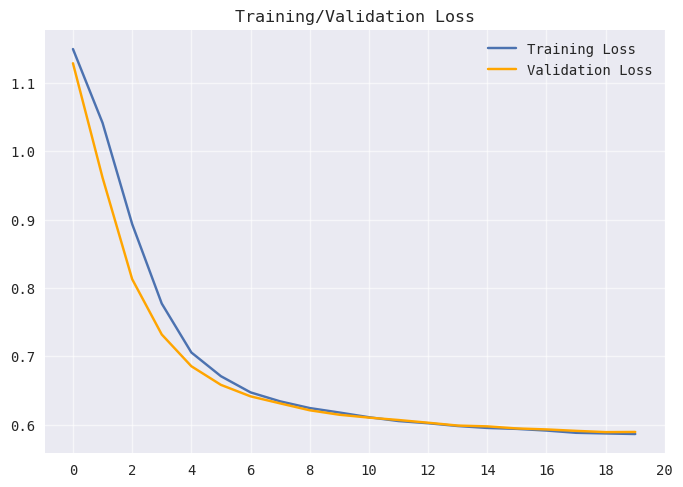

In [14]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.xticks(np.linspace(0, 20, 11));
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [15]:
print(f"Predicted Model Parameters:", "Weights: {}".format(Model.linear.weight), "Bias: {}".format(Model.linear.bias), sep="\n")

Predicted Model Parameters:
Weights: Parameter containing:
tensor([[-0.4204, -1.4696],
        [ 1.2360,  0.1972],
        [-0.6944,  0.2552]], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([-0.0702, -0.1233,  0.3102], device='cuda:0', requires_grad=True)


In [16]:
print(f"Shapes for Weight and Bias Tensors:", Model.linear.weight.shape, Model.linear.bias.shape, sep="\n")

Shapes for Weight and Bias Tensors:
torch.Size([3, 2])
torch.Size([3])


In [17]:
weights = Model.linear.weight.detach().cpu().numpy()
biases = Model.linear.bias.detach().cpu().numpy()

Xmin, Xmax = X[:, 0].min() - .5, X[:, 0].max() + .5
ymin, ymax = X[:, 1].min() - .5, X[:, 1].max() + .5

In [18]:
xx, yy = np.meshgrid(np.linspace(Xmin, Xmax, SIZE), np.linspace(ymin, ymax, SIZE))
grid = np.c_[xx.flatten(), yy.flatten()]

scores = grid @ weights.T + biases
predicted_classes = np.argmax(scores, axis=1).reshape(xx.shape)

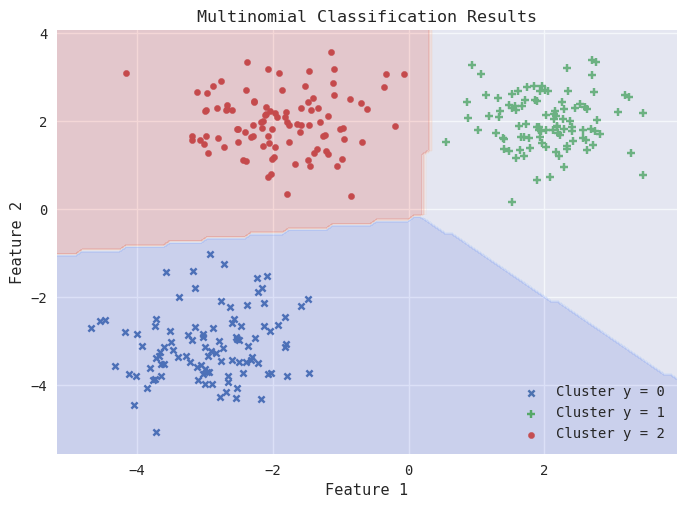

In [19]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='Cluster y = 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='Cluster y = 1', s=40)
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], marker='o', label='Cluster y = 2', s=20)

plt.contourf(xx, yy, predicted_classes, alpha=0.2, cmap=plt.cm.coolwarm)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("Multinomial Classification Results");
plt.legend(loc='lower right');
plt.show();

In [153]:
# Testing on a New Instance
Xn = torch.tensor([-0.01992, -1.2231], dtype=DTYPE, device='cpu').unsqueeze(0)
print(f"New Instance:", Xn, Xn.shape, sep='\n')

New Instance:
tensor([[-0.0199, -1.2231]])
torch.Size([1, 2])


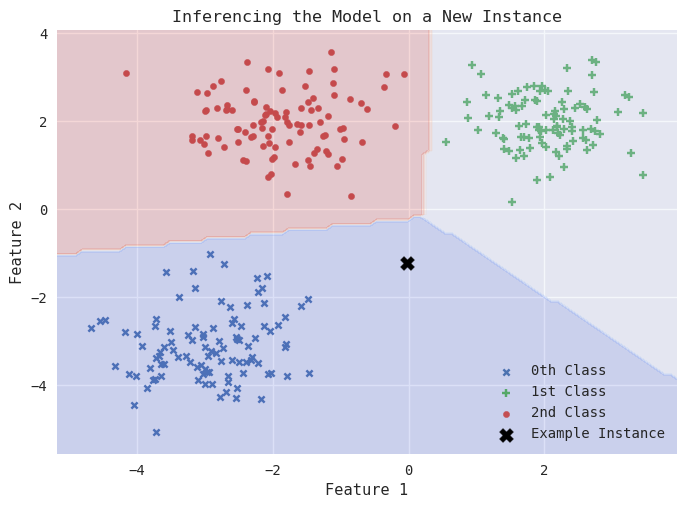

In [156]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], marker='x', label='0th Class', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], marker='+', label='1st Class', s=40)
plt.scatter(X[y == 2][:, 0], X[y == 2][:, 1], marker='o', label='2nd Class', s=20)

plt.contourf(xx, yy, predicted_classes, alpha=0.2, cmap=plt.cm.coolwarm)

# New instance
plt.scatter(Xn[:, 0], Xn[:, 1], marker='X', label="Example Instance", s=100, c='black')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("Inferencing the Model on a New Instance");
plt.legend(loc='lower right');
plt.show();

In [145]:
yn = Model(Xn.to(DEVICE))
print(f"Resulting predictions:\n{yn}")

Resulting predictions:
tensor([[0.7705, 0.0920, 0.1375]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [150]:
torch.argmax(yn, dim=1)

tensor([0], device='cuda:0')

In [148]:
probs = [f"{prob.item() * 100:.2f}%" for prob in yn.squeeze()]
print("Probabilities:", probs, sep='\n')

Probabilities:
['77.05%', '9.20%', '13.75%']
